In [1]:
#Import the Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Importing the Dataset
Dataset = pd.read_csv("../code/Data/german/german.csv")

## 数据预处理

### 1.异常值处理：三倍标准差探测法

In [3]:
for i in ['A2','A5','A13']:
    std = np.std(Dataset[i])
    mean = np.mean(Dataset[i])
    b = 3
    lower_limit = mean-b*std
    upper_limit = mean+b*std
    Dataset=Dataset.drop(Dataset[(Dataset[i]>upper_limit)|(Dataset[i]<lower_limit)].index)
X = Dataset.iloc[:, :-1]
y = Dataset.iloc[:, [-1]]

### 2.字符型数据编码

In [4]:
#list all the string value and convert them in to int values!!
#Note we are doing only labelencoder 

from sklearn.preprocessing import LabelEncoder

X =X.values
y =y.values

labelencoder = LabelEncoder()
for i in range(20):
    if (i not in [1,4,7,10,12,15,17]):
        X[:,i]=labelencoder.fit_transform(X[:, i])

### 3.基于最近邻的SMOTE抽样

In [5]:
y=y.reshape(1,-1)
y=pd.Series(y[0,:])
X=pd.DataFrame(X)
new_Dataset=pd.concat([X,y],axis=1,ignore_index=True)

In [6]:
import random
from sklearn.neighbors import NearestNeighbors
import numpy as np
class Smote:
    def __init__(self,samples,N=10,k=5):
        self.n_samples,self.n_attrs=samples.shape
        self.N=N
        self.k=k
        self.samples=samples
        self.newindex=0
       # self.synthetic=np.zeros((self.n_samples*N,self.n_attrs))

    def over_sampling(self):
        N=int(self.N/100)
        self.synthetic = np.zeros((self.n_samples * N, self.n_attrs))
        neighbors=NearestNeighbors(n_neighbors=self.k).fit(self.samples)
        print('neighbors',neighbors)
        for i in range(len(self.samples)):
            nnarray=neighbors.kneighbors(self.samples[i].reshape(1,-1),return_distance=False)[0]
            #print nnarray
            self._populate(N,i,nnarray)
        return self.synthetic


    # for each minority class samples,choose N of the k nearest neighbors and generate N synthetic samples.
    def _populate(self,N,i,nnarray):
        for j in range(N):
            nn=random.randint(0,self.k-1)
            dif=self.samples[nnarray[nn]]-self.samples[i]
            gap=random.random()
            self.synthetic[self.newindex]=self.samples[i]+gap*dif
            self.newindex+=1

# print(new_Dataset.iloc[(new_Dataset[20]==2).index])
# print((new_Dataset[20]==[2]).index)
a=new_Dataset.iloc[new_Dataset[new_Dataset[20]==2].index]
# a=np.array([[1,2,3],[4,5,6],[2,3,1],[2,1,2],[2,3,4],[2,3,4]])
a=np.array(a.iloc[:,:-1])
s=pd.DataFrame(Smote(a,N=200).over_sampling())
z=pd.Series([2]*len(s))
s=pd.concat([pd.DataFrame(s),z],axis=1,ignore_index=True)
all_Dataset=new_Dataset.append(s)
all_Dataset.columns=Dataset.columns

X = all_Dataset.iloc[:, :-1]
y = all_Dataset.iloc[:, [-1]]

neighbors NearestNeighbors()


In [7]:
# from sklearn.preprocessing import OneHotEncoder
# onehot_X=OneHotEncoder()
# # X[:,[0,2,3,5,6,8,9,11,13,14,16]]= onehot_X.fit_transform(X[:,[1,4,7,10,12,15,17]]).toarray()
# # X=np.column_stack((X,onehot_X.fit_transform(X[:,[1,4,7,10,12,15,17]]).toarray()))
# S=onehot_X.fit_transform(X[:,[1,4,7,10,12,15,17]]).toarray()
# np.delete(X, [1,4,7,10,12,15,17], axis=1)
# X=np.column_stack((X,S))

### 4.Relief F 特征选择算法

In [8]:
import numpy as np
from random import randrange


def relief(features, labels, times):   # 传入特征矩阵，标签矩阵和随机选择的次数，因为有可能样本有很多，所以我们随机选择若干个样本来计算;这里的矩阵都是np.array
    (n_samples, n_features) = np.shape(features)
    delta = []
    delta_features = []
    delta_index = []
    sample_distance = sap_distance(features)  # 计算每两个样本之间的距离
    new_features = normalize(features)        # 对特征值归一化

    """
    # 下面开始计算相关统计量，并对各个特征的相关统计量进行比较，最后返回各个特征值相关统计量从高到低的排名
    # 这是将随机选取的样本代入计算出来的delta
    for i in range(0, times):
        randnum = randrange(0, n_samples, 1)        # 生成一个随机数
        one_sample = features[randnum]        # 随机选择一个样本
        (nearhit, nearmiss, nearhit_index, nearmiss_index) = search_near(sample_distance, labels, randnum, features)  # 找出猜中近邻和猜错近邻,nearhit为猜中近邻样本的行向量
        delta.append(relevant_feature(nearhit_index, nearmiss_index, new_features, randnum))  # 计算相关统计量矩阵
    delta = np.asarray(delta)
    for j in range(0, n_features):
        delta_features.append(np.sum(delta[:, j]))
    midd = list(set(delta_features))
    midd.sort(reverse=True)
    for p in midd:
        for q in range(0, len(delta_features)):
            if delta_features[q] == p:
                delta_index.append(q)
    return delta_index
    """
    # 这是将所有样本都带入计算的delta
    for i in range(0, n_samples):
        (nearhit, nearmiss, nearhit_index, nearmiss_index) = search_near(sample_distance, labels, i,
                                                                         features)  # 找出猜中近邻和猜错近邻,nearhit为猜中近邻样本的行向量
        delta.append(relevant_feature(nearhit_index, nearmiss_index, new_features, i))  # 计算相关统计量矩阵
    delta = np.asarray(delta)
    for j in range(0, n_features):
        delta_features.append(np.sum(delta[:, j]))
    midd = list(set(delta_features))
    midd.sort(reverse=True)
    for p in midd:
        for q in range(0, len(delta_features)):
            if delta_features[q] == p:
                delta_index.append(q)
    return delta_index


def normalize(features):
    (n_samples, n_features) = np.shape(features)
    print("shape=", n_samples, n_features)
    fe_max = []
    fe_min = []
    n_deno = []
    new_features = np.zeros((n_samples, n_features))
    print("new_features=", new_features)
    for i in range(0, n_features):
        max_index = np.argmax(features[:, i])
        min_index = np.argmin(features[:, i])
        fe_max.append(features[max_index, i])  # 计算每一个特征的最大值
        fe_min.append(features[min_index, i])  # 计算每一个特征的最小值
    n_deno = np.asarray(fe_max) - np.asarray(fe_min)  # 求出归一化的分母
    for j in range(0, n_features):
        for k in range(0, n_samples):
            new_features[k, j] = (features[k, j]-fe_min[j]) / n_deno[j]  # 归一化
    return new_features

def sap_distance(features):
    (n_samples, n_features) = np.shape(features)
    distance = np.zeros((n_samples, n_samples))
    for i in range(0, n_samples):
        for j in range(0, n_samples):
            diff_distance = features[i]-features[j]
            if i == j:
                distance[i, j] = 9999
            else:
                distance[i, j] = euclid_distance(diff_distance)  # 使用欧几里德距离定义样本之间的距离
    print("距离：",distance)
    return distance

def euclid_distance(diff_distance):
    counter = np.power(diff_distance, 2)
    counter = np.sum(counter)
    counter = np.sqrt(counter)
    return counter

def search_near(sample_distance, labels, randnum, feartures):
    (n_samples, n_features) = np.shape(feartures)
    nearhit_list = []
    nearmiss_list = []
    hit_index = []
    miss_index = []
    for i in range(0, n_samples):
        if labels[i] == labels[randnum]:
            nearhit_list.append(sample_distance[i, randnum])  # 将距离放在一个列表里面
            hit_index.append(i)                                 # 将样本标号放在另一个列表里面
        else:
            nearmiss_list.append(sample_distance[i, randnum])
            miss_index.append(i)
    nearhit_dis_index = nearhit_list.index(min(nearhit_list))   # 算出猜中近邻
    nearhit_index = hit_index[nearhit_dis_index]                # 将猜中近邻的样本标号赋给nearhit_index

    nearmiss_dis_index = nearmiss_list.index(min(nearmiss_list))
    nearmiss_index = miss_index[nearmiss_dis_index]


    nearhit = feartures[nearhit_index]
    nearmiss = feartures[nearmiss_index]

    return nearhit, nearmiss, nearhit_index, nearmiss_index

def relevant_feature(nearhit_index, nearmiss_index, new_features, randnum):
    diff_hit = abs(new_features[nearhit_index]-new_features[randnum])
    diff_miss = abs(new_features[nearmiss_index]-new_features[randnum])
    delta = -np.power(diff_hit, 2)+np.power(diff_miss, 2)
    return delta



out_features = np.array(X)
labels = np.array(y)
times = 2
features_importance = relief(out_features, labels, times)
print("排序：", features_importance)

距离： [[9999.         4782.39992054  927.21788162 ... 7029.06923755
   651.61726017  673.57187252]
 [4782.39992054 9999.         3855.26549021 ... 2246.95009604
  4131.86248529 4110.77511511]
 [ 927.21788162 3855.26549021 9999.         ... 6101.98508005
   278.16476993  258.81342904]
 ...
 [7029.06923755 2246.95009604 6101.98508005 ... 9999.
  6378.72553634 6357.67826295]
 [ 651.61726017 4131.86248529  278.16476993 ... 6378.72553634
  9999.           25.23633938]
 [ 673.57187252 4110.77511511  258.81342904 ... 6357.67826295
    25.23633938 9999.        ]]
shape= 1503 20
new_features= [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
排序： [0, 18, 5, 13, 10, 17, 7, 11, 2, 3, 6, 14, 8, 9, 16, 12, 15, 1, 4, 19]


In [9]:
new_columns=[]
for num in features_importance[:13]:# 17的效果最好
    label='A'+str(num+1)
    new_columns.append(label)
new_X=X.loc[:,new_columns]

### 5.基于熵的离散化

In [10]:
# 数据离散化

import numpy as np
import math
 
class DiscreateByEntropy:
    def __init__(self, group, threshold):
        self.maxGroup = group # 最大分组数
        self.minInfoThreshold = threshold # 停止划分的最小熵
        self.result = dict()
 
    def loadData(self,title):
        data = np.column_stack((X[title],y))
        return data
 
    # 计算按照数据指定数据分组后的Shannon熵
    def calEntropy(self, data):
        numData = len(data)
        labelCounts = {}
        for feature in data:
            # 获得标签,这里只有0或者1
            oneLabel = feature[-1]
            # 设置字典中，标签的默认值
            if labelCounts.get(oneLabel,-1) == -1:
                labelCounts[oneLabel] = 0
            # 统计同类标签的数量
            labelCounts[oneLabel] += 1
        shannoEnt = 0.0
        for key in labelCounts:
            # 同类标签出现的概率,某一标签出现的次数除以所有标签的数量
            prob = float(labelCounts[key])/numData
            # 求熵，以2为底，取对数
            shannoEnt -= prob * math.log2(prob)
        return shannoEnt
 
    # 按照调和信息熵最小化原则分割数据集
    def split(self, data):
        # inf为正无穷
        minEntropy = np.inf
        # 记录最终分割的索引
        index = -1
        # 按照第一列对数据进行排序
        sortData = data[np.argsort(data[:,0])]
        # print(sortData)
        # 初始化最终分割数据后的熵
        lastE1,lastE2 = -1, -1
        # 返回的数据区间，包括数据和对应的熵
        S1 = dict()
        S2 = dict()
        for i in range(len(data)):
            splitData1, splitData2 = sortData[:i+1], sortData[i+1:]
            # 计算信息熵
            entropy1, entropy2 = (
                self.calEntropy(splitData1),
                self.calEntropy(splitData2)
            )
            # 计算调和平均熵
            entropy = entropy1 * len(splitData1) / len(sortData) + entropy2 * len(splitData2) / len(sortData)
            if entropy < minEntropy:
                minEntropy = entropy
                index = i
                lastE1 = entropy1
                lastE2 = entropy2
        S1["entropy"] = lastE1
        S1["data"] = sortData[:index+1]
        S2["entropy"] = lastE2
        S2["data"] = sortData[index+1:]
        return S1, S2, entropy
 
    def train(self,data):
        # 需要遍历的key
        needSplitKey = [0]
 
        self.result.setdefault(0,{})
        self.result[0]["entropy"] = np.inf
        self.result[0]["data"] = data
 
        group = 1
        for key in needSplitKey:
            S1, S2, entropy = self.split(self.result[key]["data"])
            if entropy > self.minInfoThreshold and group < self.maxGroup:
                self.result[key] = S1
                newKey = max(self.result.keys()) + 1
                self.result[newKey] = S2
                needSplitKey.extend([key])
                needSplitKey.extend([newKey])
                group += 1
            else:
                break
 
if __name__ == '__main__':
    for title in ['A2','A5','A13']:
        if title in new_columns:
            dbe = DiscreateByEntropy(group=2,threshold=0.5)
            data = dbe.loadData(title)
            dbe.train(data)
            print("result is {}".format(dbe.result))
            sort=len(dbe.result.keys())
            for i in dbe.result.keys():
                num_min=np.min(dbe.result[i]['data'][:,0])
                num_max=np.max(dbe.result[i]['data'][:,0])
                new_X[title].iloc[(new_X[title]>=num_min)&(new_X[title]<=num_max)]=-i
                # X[(X[title]>=num_min)&(X[title]<num_max)]=int(i)
            new_X[title]=-new_X[title]
        else:
            pass

In [11]:
# data_all=pd.concat([new_X,y],ignore_index=True)
# data_all.to_csv("../code/Data/german/data.csv")

In [12]:
# #feature scale our independent variables 
# from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# X[:,[1,4,7,10,12,15,17]] = sc_X.fit_transform(X[:,[1,4,7,10,12,15,17]])

## 分类模型：实证研究

### 1.训练集和测试集

In [13]:
#Splitting the dataset into training and testing set's
#feature scale our independent variables 
# from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# X[:,[1,4,7,10,12,15,17]] = sc_X.fit_transform(X[:,[1,4,7,10,12,15,17]])
# from sklearn.model_selection import train_test_split
# X_train , X_test, y_train, y_test = train_test_split(new_X, y, test_size= 0.3, random_state=0, shuffle=True)


### 2.Logistic

In [14]:
#Logistic Regression model. 
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression(max_iter=1000, random_state =0, solver='liblinear',multi_class='ovr')
# classifier.fit(X_train, y_train)

# #predict with test set
# y_pred = classifier.predict(X_test)

# #evaluating our model.
# from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
# acc_train = accuracy_score(y_train, classifier.predict(X_train))
# f1_train = f1_score(y_train, classifier.predict(X_train), average= 'weighted')

# print("Traing set results")
# print("ACCURACY for train set",acc_train)
# print("F1 SCORE for train set",f1_train)

# #evaluate with test set
# acc_test = accuracy_score(y_test, y_pred)
# f1_test = f1_score(y_test, y_pred, average= 'weighted')

# print("Test set results")
# print("ACCURACY for test set",acc_test)
# print("F1 SCORE for test set",f1_test)

In [15]:
#Confusion Matrix 
# cm = confusion_matrix(y_test,y_pred)
# print(cm)

#### 交叉验证

In [16]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

ss = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
acc_train_all,f1_train_all,acc_test_all,f1_test_all=0,0,0,0
for train_index, test_index in ss.split(new_X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train_log , X_test_log, y_train_log, y_test_log=new_X.iloc[train_index],new_X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
    # print(X_train_log[1,''])
    classifier = LogisticRegression(max_iter=1000, random_state =0, solver='liblinear',multi_class='ovr')
    classifier.fit(X_train_log, y_train_log)
    #predict with test set
    y_pred_log = classifier.predict(X_test_log)
    #evaluating our model.
    
    acc_train_log = accuracy_score(y_train_log, classifier.predict(X_train_log))
    f1_train_log = f1_score(y_train_log, classifier.predict(X_train_log), average= 'weighted')
    acc_train_all+=acc_train_log
    f1_train_all+=f1_train_log
    #evaluate with test set
    acc_test_log = accuracy_score(y_test_log, y_pred_log)
    f1_test_log = f1_score(y_test_log, y_pred_log, average= 'weighted')
    acc_test_all+=acc_test_log
    f1_test_all+=f1_test_log

print("Training set results")
print("ACCURACY for train set",acc_train_all/5)
print("F1 SCORE for train set",f1_train_all/5)
print("Testing set results")
print("ACCURACY for test set",acc_test_all/5)
print("F1 SCORE for test set",f1_test_all/5)

Training set results
ACCURACY for train set 0.7317490494296578
F1 SCORE for train set 0.7302121206552595
Testing set results
ACCURACY for test set 0.7082039911308204
F1 SCORE for test set 0.7069640838005112
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-pac

### 3.SVM

In [17]:
from sklearn import svm
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

ss = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
acc_train_all,f1_train_all,acc_test_all,f1_test_all=0,0,0,0
for train_index, test_index in ss.split(new_X):
    X_train_svm , X_test_svm, y_train_svm, y_test_svm=new_X.iloc[train_index],new_X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
    # print(X_train_2[1,''])
    regr = svm.NuSVC(gamma='auto')
    regr.fit(X_train_svm, y_train_svm)
    y_pred_svm=regr.predict(X_test_svm)

    acc_train_svm = accuracy_score(y_train_svm, regr.predict(X_train_svm))
    f1_train_svm = f1_score(y_train_svm, regr.predict(X_train_svm), average= 'weighted')
    acc_train_all+=acc_train_svm
    f1_train_all+=f1_train_svm

    #evaluate with test set
    acc_test_svm = accuracy_score(y_test_svm, y_pred_svm)
    f1_test_svm = f1_score(y_test_svm, y_pred_svm, average= 'weighted')
    acc_test_all+=acc_test_svm
    f1_test_all+=f1_test_svm

print("Training set results")
print("ACCURACY for train set",acc_train_all/5)
print("F1 SCORE for train set",f1_train_all/5)
print("Testing set results")
print("ACCURACY for test set",acc_test_all/5)
print("F1 SCORE for test set",f1_test_all/5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

### 4.Decision Trees

In [18]:
from sklearn import tree
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

ss = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
acc_train_all,f1_train_all,acc_test_all,f1_test_all=0,0,0,0
for train_index, test_index in ss.split(new_X):
    X_train_tree , X_test_tree, y_train_tree, y_test_tree=new_X.iloc[train_index],new_X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
    # print(X_train_2[1,''])
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(X_train_tree, y_train_tree)
    y_pred_tree=clf.predict(X_test_tree)

    acc_train_tree = accuracy_score(y_train_tree, clf.predict(X_train_tree))
    f1_train_tree = f1_score(y_train_tree, clf.predict(X_train_tree), average= 'weighted')
    acc_train_all+=acc_train_tree
    f1_train_all+=f1_train_tree

    #evaluate with test set
    acc_test_tree = accuracy_score(y_test_tree, y_pred_tree)
    f1_test_tree = f1_score(y_test_tree, y_pred_tree, average= 'weighted')
    acc_test_all+=acc_test_tree
    f1_test_all+=f1_test_tree

print("Training set results")
print("ACCURACY for train set",acc_train_all/5)
print("F1 SCORE for train set",f1_train_all/5)
print("Testing set results")
print("ACCURACY for test set",acc_test_all/5)
print("F1 SCORE for test set",f1_test_all/5)

Training set results
ACCURACY for train set 1.0
F1 SCORE for train set 1.0
Testing set results
ACCURACY for test set 0.7760532150776054
F1 SCORE for test set 0.7754545272741487


### 5.BP神经网络

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

ss = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
acc_train_all,f1_train_all,acc_test_all,f1_test_all=0,0,0,0
for train_index, test_index in ss.split(new_X):
    X_train_bp , X_test_bp, y_train_bp, y_test_bp=new_X.iloc[train_index],new_X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
    # print(X_train_2[1,''])
    mlp = MLPClassifier(hidden_layer_sizes=(100,50,20),max_iter=500)
    mlp.fit(X_train_bp, y_train_bp)
    y_pred_bp=mlp.predict(X_test_bp)

    acc_train_bp = accuracy_score(y_train_bp, clf.predict(X_train_bp))
    f1_train_bp = f1_score(y_train_bp, clf.predict(X_train_bp), average= 'weighted')
    acc_train_all+=acc_train_bp
    f1_train_all+=f1_train_bp

    #evaluate with test set
    acc_test_bp = accuracy_score(y_test_bp, y_pred_bp)
    f1_test_bp = f1_score(y_test_bp, y_pred_bp, average= 'weighted')
    acc_test_all+=acc_test_bp
    f1_test_all+=f1_test_bp

print("Training set results")
print("ACCURACY for train set",acc_train_all/5)
print("F1 SCORE for train set",f1_train_all/5)
print("Testing set results")
print("ACCURACY for test set",acc_test_all/5)
print("F1 SCORE for test set",f1_test_all/5)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

## 数据融合：决策融合

### Bagging

In [20]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

traffic_feature=new_X
traffic_target=y

feature_train, feature_test, target_train, target_test = train_test_split(traffic_feature, traffic_target, test_size=0.3,random_state=0)
tree=DecisionTreeClassifier(criterion='entropy', max_depth=None)
# n_estimators=500:生成500个决策树
clf = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)
clf.fit(feature_train,target_train)
predict_results=clf.predict(feature_test)
print(accuracy_score(predict_results, target_test))
conf_mat = confusion_matrix(target_test, predict_results)
print(conf_mat)
print(classification_report(target_test, predict_results))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
0.8381374722838137
[[169  42]
 [ 31 209]]
              precision    recall  f1-score   support

           1       0.84      0.80      0.82       211
           2       0.83      0.87      0.85       240

    accuracy                           0.84       451
   macro avg       0.84      0.84      0.84       451
weighted avg       0.84      0.84      0.84       451



In [21]:
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

traffic_feature=new_X
traffic_target=y

feature_train, feature_test, target_train, target_test = train_test_split(traffic_feature, traffic_target, test_size=0.3,random_state=0)
tree=svm.NuSVC(gamma='auto')
# n_estimators=500:生成500个决策树
clf = BaggingClassifier(base_estimator=tree, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)
clf.fit(feature_train,target_train)
predict_results=clf.predict(feature_test)
print(accuracy_score(predict_results, target_test))
conf_mat = confusion_matrix(target_test, predict_results)
print(conf_mat)
print(classification_report(target_test, predict_results))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
0.7605321507760532
[[140  71]
 [ 37 203]]
              precision    recall  f1-score   support

           1       0.79      0.66      0.72       211
           2       0.74      0.85      0.79       240

    accuracy                           0.76       451
   macro avg       0.77      0.75      0.76       451
weighted avg       0.76      0.76      0.76       451



In [22]:
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

traffic_feature=new_X
traffic_target=y

feature_train, feature_test, target_train, target_test = train_test_split(traffic_feature, traffic_target, test_size=0.3,random_state=0)
tree=LogisticRegression(max_iter=1000, random_state =0, solver='liblinear',multi_class='ovr')
# n_estimators=500:生成500个决策树
clf = BaggingClassifier(base_estimator=tree, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)
clf.fit(feature_train,target_train)
predict_results=clf.predict(feature_test)
print(accuracy_score(predict_results, target_test))
conf_mat = confusion_matrix(target_test, predict_results)
print(conf_mat)
print(classification_report(target_test, predict_results))

0.6851441241685144
[[131  80]
 [ 62 178]]
              precision    recall  f1-score   support

           1       0.68      0.62      0.65       211
           2       0.69      0.74      0.71       240

    accuracy                           0.69       451
   macro avg       0.68      0.68      0.68       451
weighted avg       0.68      0.69      0.68       451

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [23]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

traffic_feature=new_X
traffic_target=y

feature_train, feature_test, target_train, target_test = train_test_split(traffic_feature, traffic_target, test_size=0.3,random_state=0)
tree=MLPClassifier(hidden_layer_sizes=(100,50,20),max_iter=500)
# n_estimators=500:生成500个决策树
clf = BaggingClassifier(base_estimator=tree, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)
clf.fit(feature_train,target_train)
predict_results=clf.predict(feature_test)
print(accuracy_score(predict_results, target_test))
conf_mat = confusion_matrix(target_test, predict_results)
print(conf_mat)
print(classification_report(target_test, predict_results))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
0.7960088691796009
[[150  61]
 [ 31 209]]
              precision    recall  f1-score   support

           1       0.83      0.71      0.77       211
           2       0.77      0.87      0.82       240

    accuracy                           0.80       451
   macro avg       0.80      0.79      0.79       451
weighted avg       0.80      0.80      0.79       451



### 异态并行结构

In [24]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from itertools import product
from sklearn.ensemble import VotingClassifier

feature_train, feature_test, target_train, target_test = train_test_split(new_X, y, test_size=0.3,random_state=0)

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = MLPClassifier(hidden_layer_sizes=(100,50,20),max_iter=500)
clf3 = SVC(kernel='rbf', probability=True)
clf4 = LogisticRegression(max_iter=1000, random_state =0, solver='liblinear',multi_class='ovr')
eclf = VotingClassifier(estimators=[('dt', clf1), ('mlp', clf2), ('svc', clf3),(('lr', clf4))],voting='soft', weights=[1, 1, 1, 1])

eclf.fit(feature_train,target_train)
predict_results=eclf.predict(feature_test)
print(accuracy_score(predict_results, target_test))
conf_mat = confusion_matrix(target_test, predict_results)
print(conf_mat)
print(classification_report(target_test, predict_results))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
0.7560975609756098
[[157  46]
 [ 44 122]]
              precision    recall  f1-score   support

           1       0.78      0.77      0.78       203
           2       0.73      0.73      0.73       166

    accuracy                           0.76       369
   macro avg       0.75      0.75      0.75       369
weighted avg       0.76      0.76      0.76       369



## 模型验证

### 1.可视化：准确性验证 AUC面积

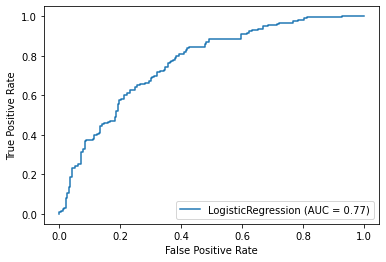

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import load_wine

classifier_disp = plot_roc_curve(classifier, X_test_log, y_test_log)

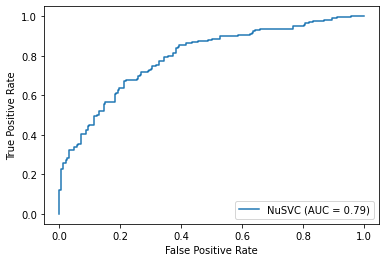

In [26]:
regr_disp = plot_roc_curve(regr, X_test_svm, y_test_svm)

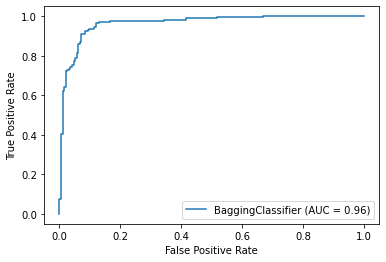

In [27]:
clf_disp = plot_roc_curve(clf, X_test_tree, y_test_tree)

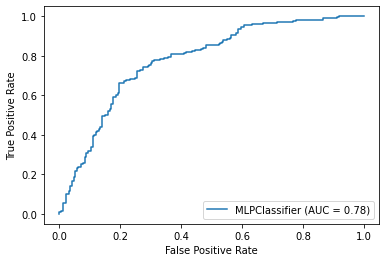

In [28]:
mlp_disp = plot_roc_curve(mlp, X_test_bp, y_test_bp)

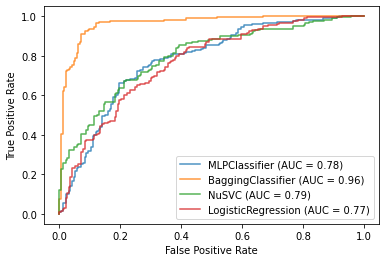

In [29]:
ax = plt.gca()
mlp_disp = plot_roc_curve(mlp,X_test_bp, y_test_bp, ax=ax, alpha=0.8)
clf_disp.plot(ax=ax, alpha=0.8)
regr_disp.plot(ax=ax, alpha=0.8)
classifier_disp.plot(ax=ax, alpha=0.8)

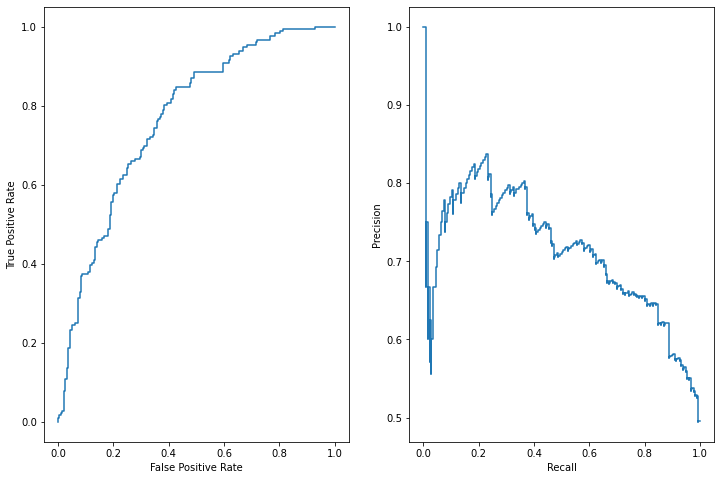

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

y_score = classifier.decision_function(X_test_log)

fpr, tpr, _ = roc_curve(y_test_log, y_score, pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)


prec, recall, _ = precision_recall_curve(y_test_log, y_score,pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

### 2.Learning curve

对于朴素的贝叶斯，随着训练集大小的增加，验证分数和训练分数都收敛到一个非常低的值。 因此，我们可能不会从更多的训练数据中受益匪浅。

相反，对于少量数据，SVM的训练得分远大于验证得分。 添加更多的训练样本将最有可能增加泛化性。

In [31]:
# print(__doc__)

# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.neural_network import MLPClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn import tree
# from sklearn.datasets import load_digits
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit


# def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
#     """
#     Generate 3 plots: the test and training learning curve, the training
#     samples vs fit times curve, the fit times vs score curve.

#     Parameters
#     ----------
#     estimator : estimator instance
#         An estimator instance implementing `fit` and `predict` methods which
#         will be cloned for each validation.

#     title : str
#         Title for the chart.

#     X : array-like of shape (n_samples, n_features)
#         Training vector, where ``n_samples`` is the number of samples and
#         ``n_features`` is the number of features.

#     y : array-like of shape (n_samples) or (n_samples, n_features)
#         Target relative to ``X`` for classification or regression;
#         None for unsupervised learning.

#     axes : array-like of shape (3,), default=None
#         Axes to use for plotting the curves.

#     ylim : tuple of shape (2,), default=None
#         Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

#     cv : int, cross-validation generator or an iterable, default=None
#         Determines the cross-validation splitting strategy.
#         Possible inputs for cv are:

#           - None, to use the default 5-fold cross-validation,
#           - integer, to specify the number of folds.
#           - :term:`CV splitter`,
#           - An iterable yielding (train, test) splits as arrays of indices.

#         For integer/None inputs, if ``y`` is binary or multiclass,
#         :class:`StratifiedKFold` used. If the estimator is not a classifier
#         or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

#         Refer :ref:`User Guide <cross_validation>` for the various
#         cross-validators that can be used here.

#     n_jobs : int or None, default=None
#         Number of jobs to run in parallel.
#         ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
#         ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
#         for more details.

#     train_sizes : array-like of shape (n_ticks,)
#         Relative or absolute numbers of training examples that will be used to
#         generate the learning curve. If the ``dtype`` is float, it is regarded
#         as a fraction of the maximum size of the training set (that is
#         determined by the selected validation method), i.e. it has to be within
#         (0, 1]. Otherwise it is interpreted as absolute sizes of the training
#         sets. Note that for classification the number of samples usually have
#         to be big enough to contain at least one sample from each class.
#         (default: np.linspace(0.1, 1.0, 5))
#     """
#     if axes is None:
#         _, axes = plt.subplots(1, 3, figsize=(20, 5))

#     axes[0].set_title(title)
#     if ylim is not None:
#         axes[0].set_ylim(*ylim)
#     axes[0].set_xlabel("Training examples")
#     axes[0].set_ylabel("Score")

#     train_sizes, train_scores, test_scores, fit_times, _ = \
#         learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
#                        train_sizes=train_sizes,
#                        return_times=True)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     fit_times_mean = np.mean(fit_times, axis=1)
#     fit_times_std = np.std(fit_times, axis=1)

#     # Plot learning curve
#     axes[0].grid()
#     axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
#                          train_scores_mean + train_scores_std, alpha=0.1,
#                          color="r")
#     axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1,
#                          color="g")
#     axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
#     axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
#                  label="Cross-validation score")
#     axes[0].legend(loc="best")

#     # Plot n_samples vs fit_times
#     axes[1].grid()
#     axes[1].plot(train_sizes, fit_times_mean, 'o-')
#     axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
#                          fit_times_mean + fit_times_std, alpha=0.1)
#     axes[1].set_xlabel("Training examples")
#     axes[1].set_ylabel("fit_times")
#     axes[1].set_title("Scalability of the model")

#     # Plot fit_time vs score
#     axes[2].grid()
#     axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
#     axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1)
#     axes[2].set_xlabel("fit_times")
#     axes[2].set_ylabel("Score")
#     axes[2].set_title("Performance of the model")

#     return plt


# fig, axes = plt.subplots(3, 4, figsize=(20, 40))

# X, y = new_X,y

# title = "Learning Curves (neural network)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = MLPClassifier()
# plot_learning_curve(estimator, title, new_X, y, axes=axes[:, 0], ylim=(0.7, 1.01),cv=cv, n_jobs=4)

# title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = SVC(gamma=0.001)
# plot_learning_curve(estimator, title, new_X, y, axes=axes[:, 1], ylim=(0.7, 1.01),cv=cv, n_jobs=4)

# title = "Learning Curves (Logistic))"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = LogisticRegression()
# plot_learning_curve(estimator, title, new_X, y, axes=axes[:, 2], ylim=(0.7, 1.01),cv=cv, n_jobs=4)

# title = "Learning Curves (Decision Tree))"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = tree.DecisionTreeClassifier()
# plot_learning_curve(estimator, title, new_X, y, axes=axes[:, 3], ylim=(0.7, 1.01),cv=cv, n_jobs=4)

# plt.show()